# 01-Creation

Things to do:
1. Initialize root case
    1. take in FASTA file from directory
    2. save FASTA sequence as array of characters
    3. intitialize community, date
2. Create descendent communities
    1. Set number of people in each communitiy
    2. look at SIR rates  - when infected 
        1. infecting x in A - Poisson
        2. infection x in B - Poisson
        3. recovering and leaving R - Gaussian? IDK
        4. select person from each community randomly based on rate
    3. At infection, look at mutation formula and pass onto reciever
    
TODO:
 *  figure out community size x data structure - prob dictionary
 *  how to pick community?
 *  function to actually mutate sequence
    

# 0. Setup

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as ssp
import matplotlib.pyplot as plt
import pandas as pd
import random
import datetime
import seaborn as sns

from Bio import SeqIO


In [2]:
np.random.binomial(99,.25)

30

## 0.1 Functions

In [3]:
#from functions import num_infected
def num_infected(rate, Sus_I):
#inner beta, intra beta, arrays of indices for inside and outside group
#returns: arrays of index numbers for those selected
    I_inf = []

    
    num_in = int(np.random.poisson(rate))
    #print('num in: ' + str(num_in))
    #print('num out: ' + str(num_out))
    
    for i in range(num_in):
        if len(Sus_I) == 0:
            break
        I_inf.append(random.choice(Sus_I))
    return I_inf
                     


In [25]:
#==============================================================================
# mutation https://www.nature.com/articles/s41467-020-19818-2 - clock rate
#==============================================================================

def agent_mut_num(rate=0.419):
#adds mutationfor every 3 transmissions
#returns: number of mutations
    mymut = np.random.poisson(rate)
    return mymut


def spot_mutation(num, seq):
#one mutation for every 2-3 transmissions
#returns: new sequence
    swap = random.sample(range(len(seq)), num)
    seq1=seq.copy()
    for i in swap:
        conversion = ['A', 'C', 'T', 'G']
        spot = seq1[i]
        conversion.remove(spot)
        seq1[i] = random.choice(conversion)
    return seq1

In [5]:
def spot_mutation_int(num, seq):
#one mutation for every 2-3 transmissions
#returns: new sequence
    swap = random.sample(range(len(seq)), num)
    seq1=seq.copy()
    for i in swap:
        print(i)
        conversion = [0, 1, 2, 3]
        spot = seq1[i]
        conversion.remove(spot)
        seq1[i] = random.choice(conversion)
    return seq1

In [6]:
w = [1,1,1,2,2,3,0,0,0,0,3,2,1,3,3,3,1]
v = w.copy()

In [7]:
v= spot_mutation_int(agent_mut_num(2),w)
np.array_equal(v,w)

7


False

In [8]:
np.array_equal(v,w)

False

In [9]:
agent_mut_num(30)

19

In [10]:
#==============================================================================
# recovery 
#==============================================================================

def recovery_odds(k=1,theta=10):
#gamma functoin - time until next event
                     #k is number of events (one)
                     #theta is avg num days to infection (10)
#returns: time in days until recovery. save and then check if infection day is higher than that
    day = round(np.random.gamma(k, theta, 1)[0])
    return day

In [11]:
base = SeqIO.to_dict(SeqIO.parse('data/reference.fasta', 'fasta'))
ref= base['base_case']
refseq = np.array(ref)

In [12]:
refseq2 = []
dik={}
dik['A'] = 0
dik['C'] = 1
dik['T'] = 2
dik['G'] = 3
for a in refseq:
    refseq2.append(dik[a])

In [13]:
refseq2 = np.array(refseq2).T

## 0.2 Time Steps
* chosing to run for 31 days
* [equation](https://cse.cs.ucsb.edu/sites/default/files/publications/NewTau052.pdf)  for determining Tau: IGNORING ME - ASK IN GROUP MEETING

In [14]:
times = np.arange(0,31)


# 1. Initializing Cases/Agents

In [104]:
allseq = {}

### 1.1 Community Stat
    start initalize all communities and starting state of susceptible

In [105]:
char = ['accession','community','state','infection_date','index_ID','descendants', 'recovery']
agents = pd.DataFrame(columns=char, index=range(400))

agents['state'] = 'S'
    #initiialize all as Susceptible - 'S'
agents['community'] = np.random.binomial(1,0.5,400) 
    #random 50/50 to be in community A vs B. multinomial if more communitis
#agents['community'] = [ chr(x+65) for x in agents.community]
    #convert numerical binomial to char. 0 - A, 1- B...///////////
agents['descendants'] = [[]] * agents.shape[0]
    
#don't need to save sequence here, save to dict w key as accession

### 1.2 Initial I

In [108]:
agents.at[0, 'accession'] = int(1000)
agents.at[0, 'state'] = 'I'
agents.at[0, 'infection_date'] = datetime.date.fromisoformat('2020-03-01')
k =  round(np.random.exponential(10))
agents.at[0,'recovery'] = datetime.date.fromisoformat('2020-03-01') + datetime.timedelta(days=k)
allseq[1000] = refseq
agents


,accession,community,state,infection_date,index_ID,descendants,recovery
0,1000,0,I,2020-03-01,NaN,[],2020-03-12
1,NaN,1,S,NaN,NaN,[],NaN
2,NaN,0,S,NaN,NaN,[],NaN
3,NaN,0,S,NaN,NaN,[],NaN
4,NaN,0,S,NaN,NaN,[],NaN
...,...,...,...,...,...,...,...
395,NaN,1,S,NaN,NaN,[],NaN
396,NaN,0,S,NaN,NaN,[],NaN
397,NaN,0,S,NaN,NaN,[],NaN
398,NaN,0,S,NaN,NaN,[],NaN


In [109]:
allseq

{1000: array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1')}

### 1.3 Infection

In [110]:
for day in times:
    step = int(day)
    hoy = datetime.date.fromisoformat('2020-03-01') + datetime.timedelta(days=step)
    sus = agents[agents.state=="S"]
    inf = agents[agents.state=="I"]

    for ii in inf.T:
        #print(ii)
        if agents.iloc[ii].recovery == hoy:
            agents.at[ii, 'state'] = 'R'
            break
        com = agents.iloc[ii].community
        ins = num_infected(0.3, sus[sus.community==com].index)
        for i in ins:
            ID =  random.randint(1,9999)
            indID = agents.iloc[ii].accession
            day_sick = round(np.random.exponential(10))
            agents.at[i, 'accession'] = ID
            agents.at[i, 'state'] = "I"
            agents.at[i, 'infection_date'] = hoy
            agents.at[i, 'index_ID'] = indID
            agents.at[i, 'recovery'] = hoy + datetime.timedelta(days=day_sick)
            #agents.at[ii, 'descendants'] = np.append(i) #this is logic is so wrong skskkssk fix
            allseq[ID] = spot_mutation(agent_mut_num(day_sick*.081), allseq[indID])
            #day_sick*.081
            
            
        outs = num_infected(0.15, sus[sus.community!=com].index)
        for o in outs:
            ID =  random.randint(1,9999)
            indID = agents.iloc[ii].accession
            day_sick = round(np.random.exponential(10))
            agents.at[o, 'accession'] = ID
            agents.at[o, 'state'] = "I"
            agents.at[o, 'infection_date'] = hoy
            agents.at[o, 'index_ID'] = indID
            agents.at[o, 'recovery'] = hoy + datetime.timedelta(days=day_sick)
            #agents.at[ii, 'descendants'] = np.append(o) #this is logic is so wrong skskkssk fix
            #day_sick*.081
            allseq[ID] = spot_mutation(agent_mut_num(day_sick*.081), allseq[indID])
        #print(ins)
        #print(outs)
    print("today " + str(day))
    
    


today 0
today 1
today 2
today 3
today 4
today 5
today 6
today 7
today 8
today 9
today 10
today 11
today 12
today 13
today 14
today 15
today 16
today 17
today 18
today 19
today 20
today 21
today 22
today 23
today 24
today 25
today 26
today 27
today 28
today 29
today 30


In [111]:
strains = []
i = 22670
for a in agents.index:
    strains.append(stra.format(num=i))
    i+=1
agents['strains']=strains
agents['region'] = ['North America'] * len(agents.index)
agents['country'] = ['USA'] * len(agents.index)

# 2. Summary Info

In [199]:
agents

,accession,community,state,infection_date,index_ID,descendants,recovery,strains,region,country
0,1000,0,R,2020-03-01,NaN,[],2020-03-12,G22670,North America,USA
1,NaN,1,S,NaN,NaN,[],NaN,G22671,North America,USA
2,NaN,0,S,NaN,NaN,[],NaN,G22672,North America,USA
3,5031,0,I,2020-03-26,4453,[],2020-04-11,G22673,North America,USA
4,NaN,0,S,NaN,NaN,[],NaN,G22674,North America,USA
...,...,...,...,...,...,...,...,...,...,...
395,NaN,1,S,NaN,NaN,[],NaN,G23065,North America,USA
396,NaN,0,S,NaN,NaN,[],NaN,G23066,North America,USA
397,NaN,0,S,NaN,NaN,[],NaN,G23067,North America,USA
398,9866,0,I,2020-03-31,5031,[],2020-04-06,G23068,North America,USA


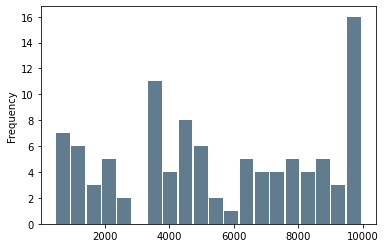

In [200]:
agents.index_ID.plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.ylabel=('Frequency')
plt.xlabel=('Infector')

In [201]:
tot=0
for a in allseq:
    for j in allseq:
        if np.array_equal(allseq[a], allseq[j]):
            tot+=1


In [202]:
tot

473

In [203]:
len(allseq)

103

In [204]:
tot/(103*102/2)

0.0900437845040929

In [205]:
agents

,accession,community,state,infection_date,index_ID,descendants,recovery,strains,region,country
0,1000,0,R,2020-03-01,NaN,[],2020-03-12,G22670,North America,USA
1,NaN,1,S,NaN,NaN,[],NaN,G22671,North America,USA
2,NaN,0,S,NaN,NaN,[],NaN,G22672,North America,USA
3,5031,0,I,2020-03-26,4453,[],2020-04-11,G22673,North America,USA
4,NaN,0,S,NaN,NaN,[],NaN,G22674,North America,USA
...,...,...,...,...,...,...,...,...,...,...
395,NaN,1,S,NaN,NaN,[],NaN,G23065,North America,USA
396,NaN,0,S,NaN,NaN,[],NaN,G23066,North America,USA
397,NaN,0,S,NaN,NaN,[],NaN,G23067,North America,USA
398,9866,0,I,2020-03-31,5031,[],2020-04-06,G23068,North America,USA


* list of places
    * create actual edges in NextStrain
* separate list of two communities
    * random  selection of agents in each community - based on parameters for each comm
        * sequenicng frequency in comm A
        * ratio btwn teh 2 - >,<1
    * decrease by x - .5, .25, etc
* still provide initial sequence - youngest count as root in random selection
* see how many of correctly directed edges are present in constructed tree
    * function of the two parameters - % correct
    
TODO:
    - script to automate creation of fasta x metadata file (400-1k agents)?
    - creation and running of snakemake
    - function to determine ground truth - list of directed ages?
    - in/out of nextstrain
    - feed all to see how initially accurate nextstrain is

In [206]:
base

{'base_case': SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA'), id='base_case', name='base_case', description='base_case', dbxrefs=[])}

# 3. Exporting

### 3.1 Demographic Info

In [210]:
gnm = agents[agents.state != 'S']

In [213]:
gnm

,accession,community,state,infection_date,index_ID,descendants,recovery,strains,region,country,local
0,1000,0,R,2020-03-01,NaN,[],2020-03-12,G22670,North America,USA,community A
3,5031,0,I,2020-03-26,4453,[],2020-04-11,G22673,North America,USA,community A
10,9857,1,I,2020-03-19,9962,[],2020-04-02,G22680,North America,USA,community B
14,6658,1,I,2020-03-29,7814,[],2020-04-03,G22684,North America,USA,community B
20,3492,0,R,2020-03-07,1000,[],2020-03-14,G22690,North America,USA,community A
...,...,...,...,...,...,...,...,...,...,...,...
384,1704,0,I,2020-03-25,703,[],2020-04-04,G23054,North America,USA,community A
387,7770,1,I,2020-03-24,9857,[],2020-04-04,G23057,North America,USA,community B
388,7540,1,I,2020-03-19,4224,[],2020-03-29,G23058,North America,USA,community B
391,4186,0,I,2020-03-26,1537,[],2020-04-11,G23061,North America,USA,community A


In [212]:
location = []
conv = {}
conv[0]='community A'
conv[1] ='community B'
for i in gnm.community:
    location.append(conv[i])
gnm['local'] = location

<ipython-input-212-b4ff5db87d92>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnm['local'] = location


In [214]:
gnm.to_csv('background.tsv', sep='\t', 
              columns=['strains', 'accession','infection_date','region','country','local'],
             index=False)


In [198]:
allseq.keys()

dict_keys([1000, 3094, 2397, 3492, 4287, 6300, 9962, 2676, 4224, 2192, 6220, 7457, 3655, 8315, 1899, 9857, 5012, 4453, 7540, 8670, 8400, 4731, 9115, 6955, 4551, 5602, 9622, 1692, 1537, 8040, 3467, 9484, 4892, 703, 4985, 792, 9470, 7373, 1209, 7770, 1603, 7927, 3614, 8467, 2904, 3428, 5050, 1663, 407, 458, 6989, 1704, 5623, 3553, 332, 7814, 8648, 8175, 1595, 8047, 4757, 5031, 9677, 4186, 7639, 3661, 8104, 3329, 1123, 2603, 5790, 3005, 6658, 9096, 8517, 7124, 2702, 2898, 923, 7388, 3933, 9683, 7094, 7784, 517, 4531, 7034, 5235, 9499, 3669, 8369, 6700, 4881, 7930, 9516, 7951, 9866, 3947, 7086, 9801, 7735, 3006, 7338])

gnm.accession

In [176]:
gnm2 = gnm.reset_index()


### 3.2 FASTA File

In [180]:
ofile = open("allseqs.txt", "w")

for i in gnm2.index:
    me = gnm.iloc[i]
    ofile.write(">" + me.strains + "\n" +''.join(allseq[me.accession]) + "\n")

    #do not forget to close it

ofile.close()

In [167]:
print(i in gnm.index)

True


ValueError: DataFrame constructor not properly called!

In [179]:
gnm2.iloc[10]

index                        48
accession                  6700
community                     0
state                         I
infection_date       2020-03-30
index_ID                    923
descendants                  []
recovery             2020-04-01
strains                  G22718
region            North America
country                     USA
Name: 10, dtype: object